# Importing Modules

In [1]:
# Cleanning
import pandas as pd
import numpy as np
from scipy.stats import mode

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modelling
from haversine import haversine
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import iqr
from scipy.stats import scoreatpercentile as pct
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.stats import probplot
from math import radians, cos, sin, asin, sqrt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
import xgboost
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score


# User Defined Functions

## Importing Data

In [2]:
def load_data(file, source_type="csv"):
    """
    

    Parameters
    ----------
    file : str
        Name of the file containing the data.
    source_type : str, optional
        The file type."csv" or "excel" accepted. The default is "csv".

    Returns
    -------
    file1 : Dataframe
        A DataFrame containing the data.

    """

    path = "Data/" + file

    try:

        read_f = eval(f'pd.read_{source_type}')
        file1 = read_f(path)
        return file1

    except AttributeError:

        print("Sorry, your input source_type is not supported. Try 'csv' or 'excel'.")


## Cleaning and Preprocessing the Data

### Standardizing Headings

In [3]:
def standard_headings(df):
    """
    

    Parameters
    ----------
    df : DataFrame
        The DataFrame which headings will be standardized.

    Returns
    -------
    df : DataFrame
        A DataFrame with standardized headings, i.e. lower case and " " replaced by "_".

    """

    heading = df.columns
    df.columns = [clabel.lower().replace(" ", "_") for clabel in heading]
    return df


### Transform yr_renovated and yr_built into one single column

In [4]:
# Wrapper function (to use the block of code in a pipeline), only usable for this dataset
# Combine the renovation year (with many zeros, possibly missing values) and the construction year into one single column

def transform_renovated_built(df):

    yr_renovated = df["yr_renovated"]
    yr_built = df["yr_built"]
    yr_ren_built = yr_renovated.where(yr_renovated != 0, other = yr_built)
    age=  max(yr_ren_built) - yr_ren_built
    df["yr_built"] = age
    df = df.rename(columns={"yr_built":"age"})
    df = df.drop(columns=["yr_renovated"])   

    return df

### Removing specific rows

In [5]:
# Wrapper function (to use the block of code in a pipeline), only usable for this dataset
# There is one record with 33 rooms that is obviously a typo

def remove_rows(df):

    df = df[df["bedrooms"] != 33]

    return df

## Data Transformation

### X/y split | Train/test split | Numerical Variables Scaling

In [6]:
def my_transformations(x, y, test_size=0.2, numerical=True, scaler="standard", 
                       categorical=True, ordinal_dict=None, nominal_list=[]):
    """


    Parameters
    ----------
    x : DataFrame or Series
        Estimators
    y : DataFrame or Series
        Target Variable
    test_size : float, optional
        Size in fraction (0-1) of the test set. The default is 0.2.
    numerical : Boolean, optional
        Numerical Flag, True if the output DataFrame should contain numerical variables. 
        The default is True.
    scaler : String, optional
        The type of numerical scaling method to be used. Values accepted are 
        "standard" and "minmax". The default is "standard".
    categorical : Boolean, optional
        Categorical Flag, True if the output DataFrame should contain categorical variables.
        The default is True.
    ordinal_dict : Dictionary, optional
        Dictionary containing the rules for the ordinal encoding. The default is None.
    nominal_list : List, optional
        List containing the columns that require one-hot encoding . The default is [].

    Returns
    -------
    dict
        A dictionary containing two records, "train" and "test".
        These two are lists containing the transformed train and test set:
            - Scaled Numerical columns
            - Ordinal Encoded columns
            - One-Hot Encoded columns
            - Target Variable

    """

    # Train/Test Split

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=0)

    x_train = x_train.reset_index(drop=True)
    x_test = x_test.reset_index(drop=True)

    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Numerical variables - assign and scale them

    if numerical:

        x_train_num = x_train._get_numeric_data()
        x_test_num = x_test._get_numeric_data()

        if scaler is not None:

            if scaler == "minmax":

                scaler = MinMaxScaler()

            elif scaler == "standard":

                scaler = StandardScaler()

            else:

                print("The input scaling method is not supported. Please use 'standard' or 'minmax'.")
                return

            scaler.fit(x_train_num)
            output_train_num = pd.DataFrame(scaler.transform(x_train_num), columns=x_train_num.columns)
            output_test_num = pd.DataFrame(scaler.transform(x_test_num), columns=x_test_num.columns)

        else:

            output_train_num = x_train_num
            output_test_num = x_test_num
    else:

        output_train_num = "None"
        output_test_num = "None"

    # Categorical variables - assign and encode them

    if categorical:

        x_train_cat = x_train.select_dtypes(["category", "object"])
        x_test_cat = x_test.select_dtypes(["category", "object"])

        # Encoding - Ordinals

        if ordinal_dict is not None:

            x_train_cat_ord = x_train_cat[list(ordinal_dict.keys())]
            x_test_cat_ord = x_test_cat[list(ordinal_dict.keys())]

            categories = [t[1] for t in list(ordinal_dict.items())]

            ordinal_encoder = OrdinalEncoder(categories=categories)
            x_train_cat[x_train_cat_ord.columns] = pd.DataFrame(ordinal_encoder.fit_transform(x_train_cat_ord)
                                                                , columns=x_train_cat_ord.columns)
            output_train_cat_ord = x_train_cat.drop(nominal_list, axis=1)
            x_test_cat[x_test_cat_ord.columns] = pd.DataFrame(ordinal_encoder.fit_transform(x_test_cat_ord)
                                                              , columns=x_test_cat_ord.columns)
            output_test_cat_ord = x_test_cat.drop(nominal_list, axis=1)

        else:

            output_train_cat_ord = x_train_cat
            output_test_cat_ord = x_test_cat

        # Encoding - Nominals

        if len(nominal_list) != 0:

            output_train_cat_nom = pd.get_dummies(x_train_cat.loc[:, nominal_list], drop_first=True)
            output_test_cat_nom = pd.get_dummies(x_test_cat.loc[:, nominal_list], drop_first=True)

        else:

            output_train_cat_nom = "None"
            output_test_cat_nom = "None"

    else:

        output_train_cat_ord = "None"
        output_train_cat_nom = "None"
        output_test_cat_ord = "None"
        output_test_cat_nom = "None"

    return {"train": [output_train_num, output_train_cat_ord, output_train_cat_nom, y_train],
            "test": [output_test_num, output_test_cat_ord, output_test_cat_nom, y_test]}


### Normalization

In [7]:
def var_normalization(df):
    """


    Parameters
    ----------
    df : DataFrame or Series
        Target Dataframe to be nomalized.

    Returns
    -------
    transformer : Sklearn Transformet Object
        Box-Cox Transformer Object.
    power_norm : DataFrame or Series
        Target DataFrame or Series Normalized using a box-cox transformation.

    """

    transformer = PowerTransformer(method="box-cox").fit(df.to_numpy().reshape(-1, 1))
    power_norm = transformer.transform(df.to_numpy().reshape(-1, 1))
    power_norm = pd.DataFrame(power_norm)[0]

    return transformer, power_norm

In [8]:
# Wrapper function (to use the block of code in a pipeline), only usable for this dataset
# Normalization Tranform of price and sqft_living

def normalizations(df):

    df["price"] = np.log(df["price"])
    df["sqft_living"] = var_normalization(df["sqft_living"])[1]

    return df

### Location Engineered Feature

In [9]:
# Wrapper function (to use the block of code in a pipeline), only usable for this dataset
# Engineered Feature to treat the location data as the distance of each house to two hot spots, bellevue and Seattle downtown

def dist_to(df):

    latlong = df.loc[:, ['lat', 'long']]
    latlong_tuple = list(zip(latlong.loc[:, 'lat'], latlong.loc[:, 'long']))
    latlong["lat_long"] = latlong_tuple

    dist_to_seattle = latlong.loc[:, 'lat_long'].apply(haversine, point2=(47.609395, -122.336283))
    dist_to_bellevue = latlong.loc[:, 'lat_long'].apply(haversine, point2=(47.616492, -122.188985))
    
    df.loc[:, 'dist_to_seattle'] = dist_to_seattle
    df.loc[:, 'dist_to_bellevue'] = dist_to_bellevue

    return df

## Regression Functions

### Performance Metrics

In [10]:
def r2_adjusted(x, y, y_pred, r2=None):
    """
    

    Parameters
    ----------
    x : DataFrame or Serie
        Estimators
    y : DataFrame or Serie
        Observed Target Variable.
    y_pred : DataFrame or Serie
        Predicted Target Variable.
    r2 : Float, optional
        R2 value previously calculated. The default is None.

    Returns
    -------
    r2_adj : Float
        Adjusted R2 value.

    """

    if r2 is None:

        r2 = r2_score(y, y_pred)


    r2_adj = 1 - (1 - r2) * (len(y) - 1) / (len(y) - x.shape[1] - 1)

    return r2_adj

In [11]:
def perf_regression(y_train, y_test, y_pred_train, y_pred_test, x_train, x_test):
    """
    

    Parameters
    ----------
    y_train : DataFrame or Series
        Observed Target Variable (train set).
    y_test : DataFrame or Series
        Observed Target Variable (test set).
    y_pred_train : DataFrame or Series
        Predicted Target Variable (train set).
    y_pred_test : DataFrame or Series
        Predicted Target Variable (test set).
    x_train : DataFrame or Series
        Estimators (train set).
    x_test : DataFrame or Series
        Estimators (test set).

    Returns
    -------
    performance : DataFrame
        Dataframe containing the performance metrics (MAE, MSE, RMSE, R2 and R2 adj).

    """

    performance = pd.DataFrame({'error_metric': ['mae', 'mse', 'rmse', 'r2', 'r2_adj'],
                                'train': [mae(y_train, y_pred_train),
                                          mse(y_train, y_pred_train),
                                          mse(y_train, y_pred_train, squared=False),
                                          r2_score(y_train, y_pred_train),
                                          r2_adjusted(x_train, y_train, y_pred_train)],
                                'test':  [mae(y_test, y_pred_test),
                                          mse(y_test, y_pred_test),
                                          mse(y_test, y_pred_test, squared=False),
                                          r2_score(y_test, y_pred_test),
                                          r2_adjusted(x_test, y_test, y_pred_test)]})

    performance = performance.set_index("error_metric")

    return performance


In [12]:
def regression_plots(pred_data, set_id, fig_size=(15, 5)):
    """


    Parameters
    ----------
    pred_data : Dictionary
        Contains the observed and the predicted target variable.
    set_id : String
        "train" or "test".
    fig_size : Tuple, optional
        Figure size. The default is (15, 5).

    Returns
    -------
    None.

    """

    y = pred_data["y"]
    y_pred = pred_data["y_pred"]

    fig, axs = plt.subplots(1, 3, figsize=fig_size)

    sns.regplot(x="y", y="y_pred", data=pred_data, scatter_kws={"color": "red"}, line_kws={"color": "black"}, ax=axs[0])
    sns.histplot(y - y_pred, kde=True, ax=axs[1])
    axs[2].plot(y_pred, y - y_pred, "o")
    axs[2].plot(y_pred, np.zeros(len(y_pred)), linestyle='dashed')

    axs[0].set_title(f"{set_id}".capitalize() + " Set - Observed VS Predicted")
    axs[1].set_title(f"{set_id}".capitalize() + " Set - Histogram of the Residuals")
    axs[2].set_title("Residuals by Predicted")

    axs[1].set_xlabel(f"y_{set_id}" + " - y_pred")
    axs[2].set_xlabel("Predicted")
    axs[2].set_ylabel("Residuals")

### Flexible Method Regression

In [13]:
def regression(x_train, y_train, x_test, y_test, model, cv=10, verbose=True, plot=True, y_transformer=None):
    """
    

    Parameters
    ----------
    x_train : DataFrame or Series
        Estimators (train set).
    y_train : DataFrame or Series
        Observed Target Variable (train set).
    x_test : DataFrame or Series
        Estimators (test set).
    y_test : DataFrame or Series
        Observed Target Variable (test set).
    model : Sklearn model object
        Model to be used for the prediction
    cv : Integer, optional
        Number of cross validation folds. The default is 10.
    verbose : Boolean, optional
        The default is True.
    plot : Boolean, optional
        The default is True.
    y_transformer : String or sklearn transformer object, optional
        The normalization transformer used on the target variable, if any. The default is None.

    Returns
    -------
    dict
        Results of the regression.
        - Fitted Model
        - Cross Validation Scores
        - Prediction results
        - Performance Metrics

    """

    # Model cross validation
    val_scores = cross_val_score(model, x_train, y_train, cv=cv)

    # Fit the model
    model.fit(x_train, y_train)

    # Predictions
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    if y_transformer is not None:

        if y_transformer != "log":

            y_train = pd.DataFrame(y_transformer.inverse_transform(np.array(y_train).reshape(-1, 1)))[0]
            y_pred_train = pd.DataFrame(y_transformer.inverse_transform(y_pred_train.reshape(-1, 1)))[0]

            y_test = pd.DataFrame(y_transformer.inverse_transform(np.array(y_test).reshape(-1, 1)))[0]
            y_pred_test = pd.DataFrame(y_transformer.inverse_transform(y_pred_test.reshape(-1, 1)))[0]

        elif y_transformer == "log":

            y_train = np.exp(y_train)
            y_pred_train = np.exp(y_pred_train)

            y_test = np.exp(y_test)
            y_pred_test = np.exp(y_pred_test)

    prediction_results = pd.DataFrame({"train": {"y": y_train, "y_pred": y_pred_train},
                                       "test": {"y": y_test, "y_pred": y_pred_test}})

    # Build the performance df
    performance_metrics = pd.DataFrame({"error_metric": [f'val_mean_score (k={cv})', f'val_std (k={cv})'],
                                        "train": [round(np.mean(val_scores), 3), round(np.std(val_scores), 3)],
                                        "test": ["-", "-"]})
    performance_metrics = performance_metrics.set_index("error_metric")

    # Performance Evaluation
    error_metrics = perf_regression(y_train, y_test, y_pred_train, y_pred_test, x_train, x_test)
    performance_metrics = pd.concat([performance_metrics, error_metrics], axis=0)
    performance_metrics["train"] = performance_metrics["train"].astype("object")

    if verbose:
        print("-----------------")
        print(f'The model score using K-fold cross validation (k={cv}) is {round(np.mean(val_scores), 3)} '
              f'with a standard deviation of {round(np.std(val_scores), 3)}')
        print("-----------------")
        print("The performance metrics of the model")
        display(performance_metrics)
        print("-----------------")

    if plot:
        
        regression_plots(prediction_results["train"], set_id="train", fig_size=(15, 5))
        regression_plots(prediction_results["test"], set_id="test", fig_size=(15, 5))

    return {"model": model, "val_scores": val_scores, "prediction_results": prediction_results,
            "performance_metrics": performance_metrics}

## Plotting

In [14]:
# Function to plot a correlation map

def my_correlation_heatmap(df, figsize = (16,16)):
    """
    A function to plot a correlation heatmap from a DataFrame.

    Parameters
    ----------
    df : DataFrame
        The target DataFrame
    figsize : Tuple, optional
        Tuple seting the figure size. The default is (16,16).

    Returns
    -------
    None.

    """

    # correlation matrix

    correlation_matrix = df.corr()

    # create figure and axes
    fig, ax = plt.subplots(figsize = figsize)

    # set title
    ax.set_title('Correlation Heatmap', fontweight='bold')


    sns.heatmap(correlation_matrix,  # the data for the heatmap
                annot=True,  # show the actual values of correlation
                cmap='seismic',  # provide the 'seismic' colormap
                center=0,  # specify the value at which to center the colormap
                )

## Utility Functions

In [15]:
# Function to store in a dictionary the number of nan values per column

def nan_counter(df):
    """
    

    Parameters
    ----------
    df : DataFrame
        The target DataFrame.

    Returns
    -------
    remaining_nan : Dictionary
        A dictionary with the following structure. Key is the df column, value 
        is the number of null values in the corresponding column.

    """
    
    remaining_nan = {}

    for column in df.columns:

        remaining_nan[column] = df[column][df[column].isna() == True].size

    return remaining_nan

# Initial Data Exploration

Let us load the data using the user defined function "load_data()".

In [16]:
hp_df = load_data("Data_MidTerm_Project_Real_State_Regression.xls", source_type="excel")

We standarize the headings of the columns using user defined function "standard_headings()".

In [17]:
hp_df = standard_headings(hp_df)

In [18]:
hp_df

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,3,2.50,1530,1131,3.0,0,0,3,...,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,360000
21593,6600060120,2015-02-23,4,2.50,2310,5813,2.0,0,0,3,...,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,400000
21594,1523300141,2014-06-23,2,0.75,1020,1350,2.0,0,0,3,...,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,402101
21595,291310100,2015-01-16,3,2.50,1600,2388,2.0,0,0,3,...,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,400000


We do a first check of the data using methods "info()" and "describe()."

In [19]:
hp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  int64         
 8   view           21597 non-null  int64         
 9   condition      21597 non-null  int64         
 10  grade          21597 non-null  int64         
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  int64         
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   21597 non-null  int64         
 15  zipcode        2159

In [20]:
hp_df.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,2.159700e+04
mean,4.580474e+09,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007547,0.234292,3.409825,7.657915,1788.596842,291.725008,1970.999676,84.464787,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,5.402966e+05
std,2.876736e+09,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086549,0.766390,0.650546,1.173200,827.759761,442.667800,29.375234,401.821438,53.513072,0.138552,0.140724,685.230472,27274.441950,3.673681e+05
min,1.000102e+06,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,7.800000e+04
25%,2.123049e+09,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,3.220000e+05
50%,3.904930e+09,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,4.500000e+05
75%,7.308900e+09,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,6.450000e+05
max,9.900000e+09,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,7.700000e+06


We check also the DataFrame shape. We have 21,597 records and 21 features.

In [21]:
hp_df_shape = hp_df.shape
hp_df_shape

(21597, 21)

We will also check the number of null values in all columns using the user defined function "nan_counter()."

In [22]:
nan_counter(hp_df)

{'id': 0,
 'date': 0,
 'bedrooms': 0,
 'bathrooms': 0,
 'sqft_living': 0,
 'sqft_lot': 0,
 'floors': 0,
 'waterfront': 0,
 'view': 0,
 'condition': 0,
 'grade': 0,
 'sqft_above': 0,
 'sqft_basement': 0,
 'yr_built': 0,
 'yr_renovated': 0,
 'zipcode': 0,
 'lat': 0,
 'long': 0,
 'sqft_living15': 0,
 'sqft_lot15': 0,
 'price': 0}

We drop duplicates records and check the new df size. There are no duplicates records.

In [23]:
hp_df.drop_duplicates().shape

(21597, 21)

## Price Analysis

The house price is our dependent variable. Let us create a dedicated variable for easy access and some price analysis.

In [24]:
price = hp_df["price"]

### Description and Distribution

In [25]:
# Descriptive statistics summary
price.describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

C:\Users\user\miniconda3\envs\DA_ENV\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

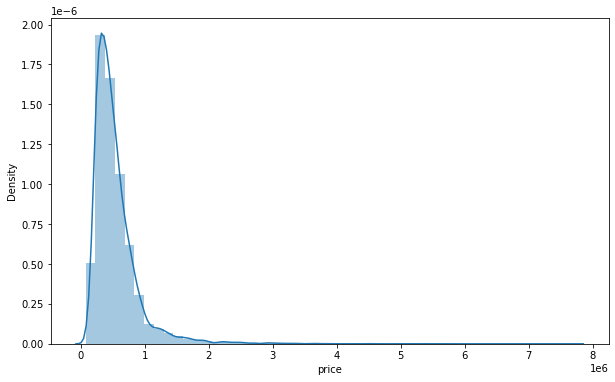

In [26]:
# Histogram

# create figure and axes
fig, ax = plt.subplots(figsize = (10,6))

sns.distplot(price)

In [27]:
# Skewness and Kurtosis
print(f"Skewness: {price.skew()}")
print(f"Kurtosis: {price.kurt()}")

Skewness: 4.023364652271239
Kurtosis: 34.54135857673376


The price is not following a normal distribution, with a high positive skewness and Kurtosis as a result of the very 'long' right tail. We will have therefore a significant number of 'outliers' in a boxplot. We will need to figure out if the outliers should be removed or if they are required to describe the data.

<AxesSubplot:xlabel='price'>

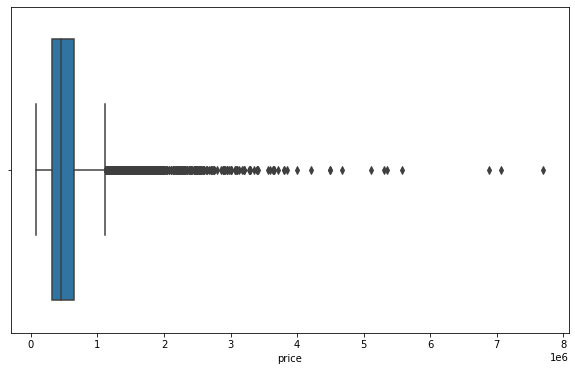

In [28]:
# Boxplot

# create figure and axes
fig, ax = plt.subplots(figsize = (10,6))

sns.boxplot(data=price, x=price)

### Feature Correlations with Price

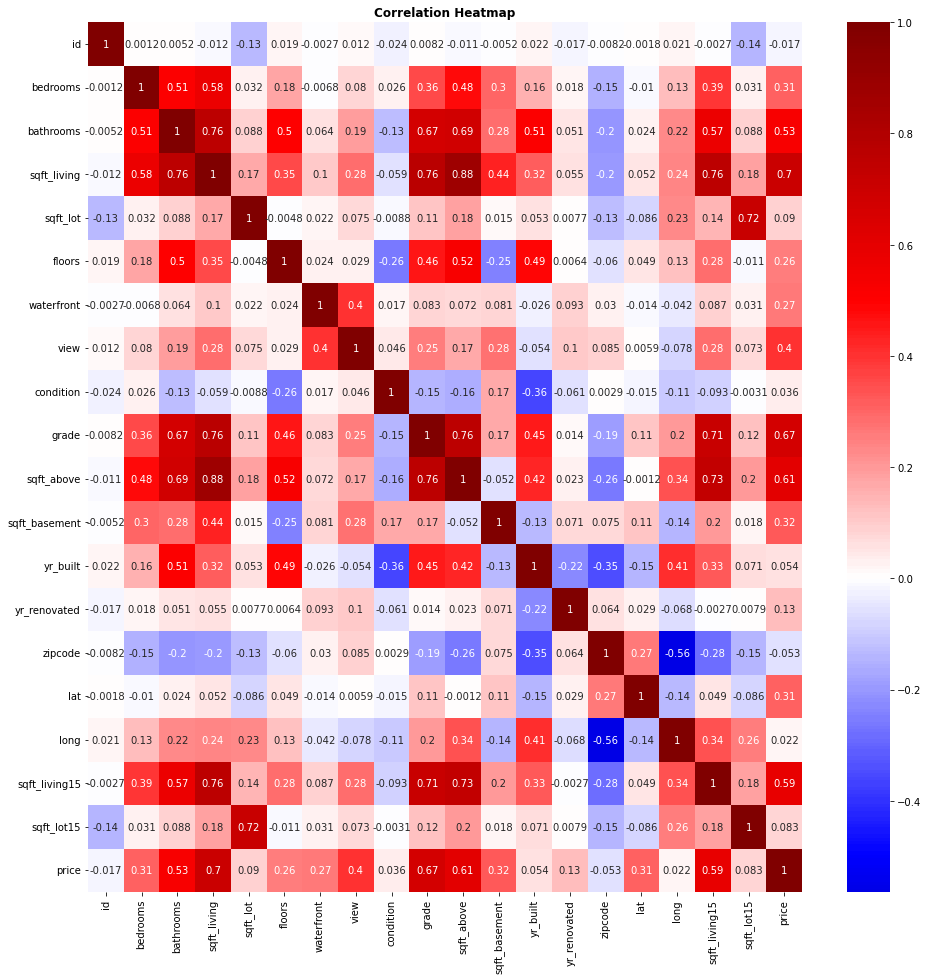

In [29]:
my_correlation_heatmap(hp_df, figsize=(16,16))

Let us plot a reduced version of the heatmap only with the 10 more correlated features.

In [30]:
price_corr_sorted = hp_df.corr()["price"].sort_values(ascending=False)
top_10_price_corr = list(price_corr_sorted.index[0:11])
top_10_price_corr

['price',
 'sqft_living',
 'grade',
 'sqft_above',
 'sqft_living15',
 'bathrooms',
 'view',
 'sqft_basement',
 'bedrooms',
 'lat',
 'waterfront']

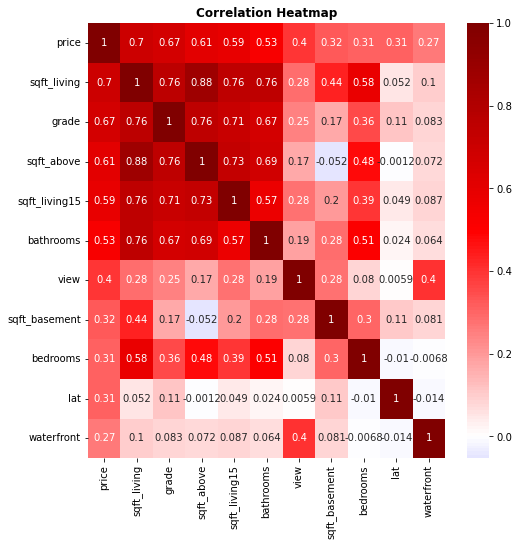

In [31]:
my_correlation_heatmap(hp_df[top_10_price_corr], figsize=(8,8))

The predictors with the highest correlation with the price are sqft_living (living area) and grade (building quality). Let us take a deeper look into these two.

It is also interesting the high correlation between sqft_linving and the other features related with area. We will drop all except sqft_living.

For the price we can use a simple scatter plot. It is obvious that there is a relatively strong linear correlation between price an sqft_living. We can also see that the houses with very high prices (outliers) have in general also very high living areas.

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

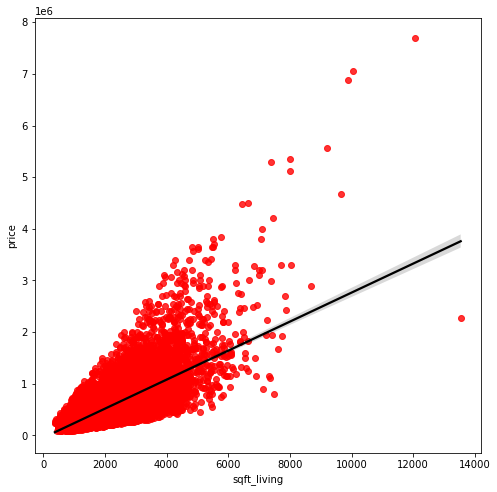

In [32]:
# Scatter plot with sqft_living
var = 'sqft_living'
data = pd.concat([price, hp_df[var]], axis=1)

fig, ax = plt.subplots(figsize = (8,8))
sns.regplot(x=var, y="price", data=data, scatter_kws={"color": "red"}, line_kws={"color": "black"})


'Grade' is a categorical variable. A boxplot is more suited therefore than a scatter plot. We can observe an interesting exponential relation between price an grade. Again the very expensive houses have in general very high grades.

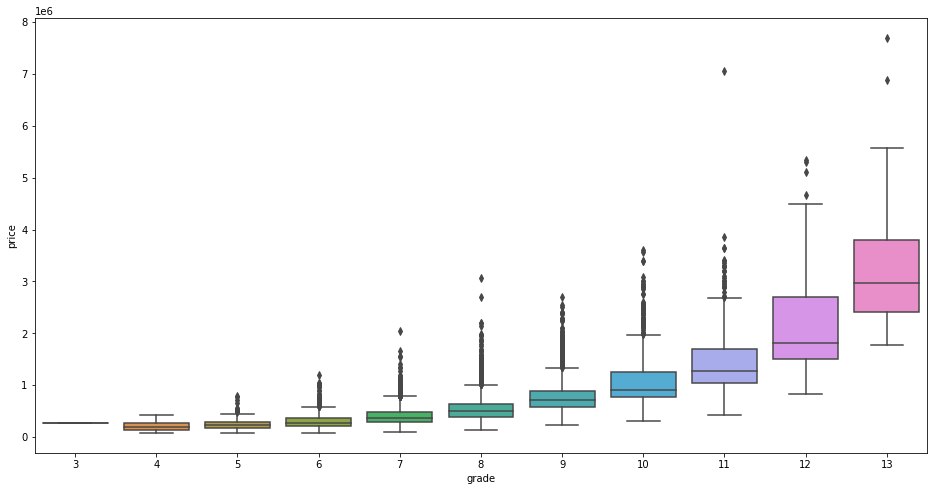

In [33]:
#box plot grade/saleprice
var = 'grade'
data = pd.concat([price, hp_df[var]], axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="price", data=data)

It is intuitive than grade an condition are kind representing the same information. Let us plot boxplots of the condtion. It is clear (also in the correlation heatmap) that condition has not a significan relation with the price. We will drop it.

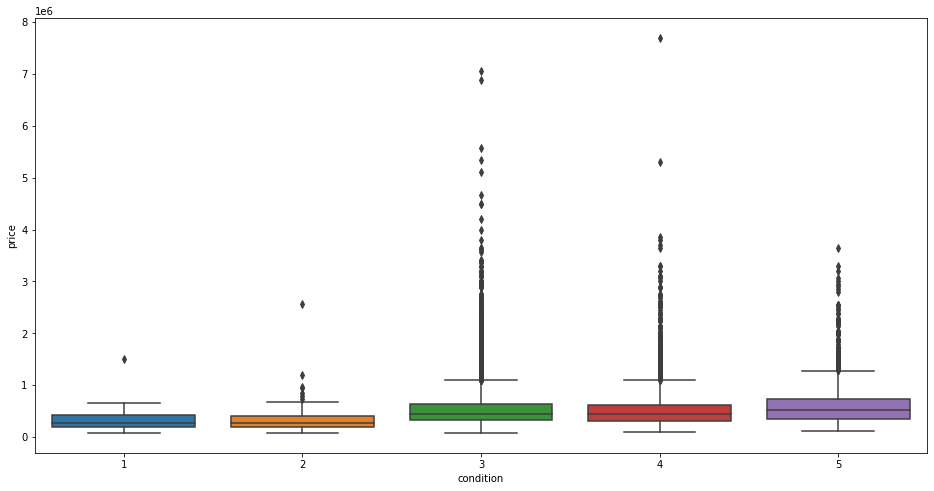

In [34]:
#box plot condition/saleprice
var = 'condition'
data = pd.concat([price, hp_df[var]], axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="price", data=data)

We plot also boxplots for the number of bedrooms and bathrooms.

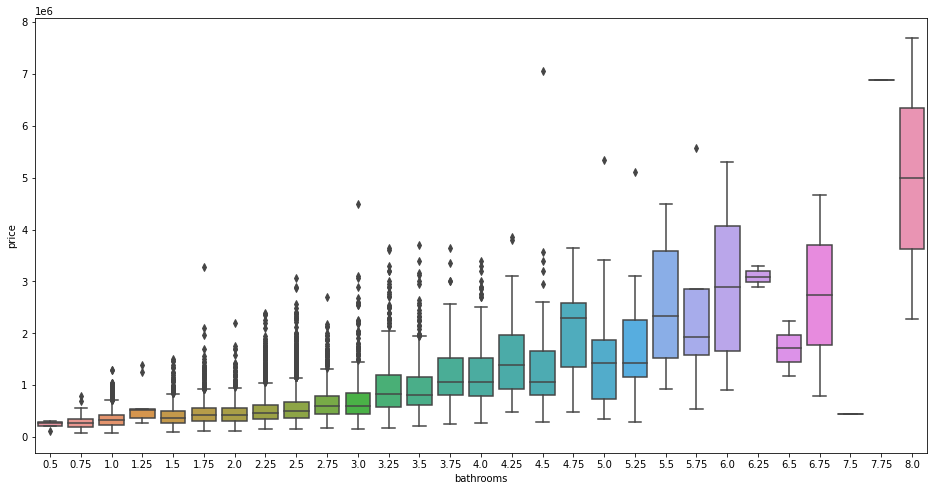

In [35]:
#box plot n bathrooms/saleprice
var = 'bathrooms'
data = pd.concat([price, hp_df[var]], axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="price", data=data)

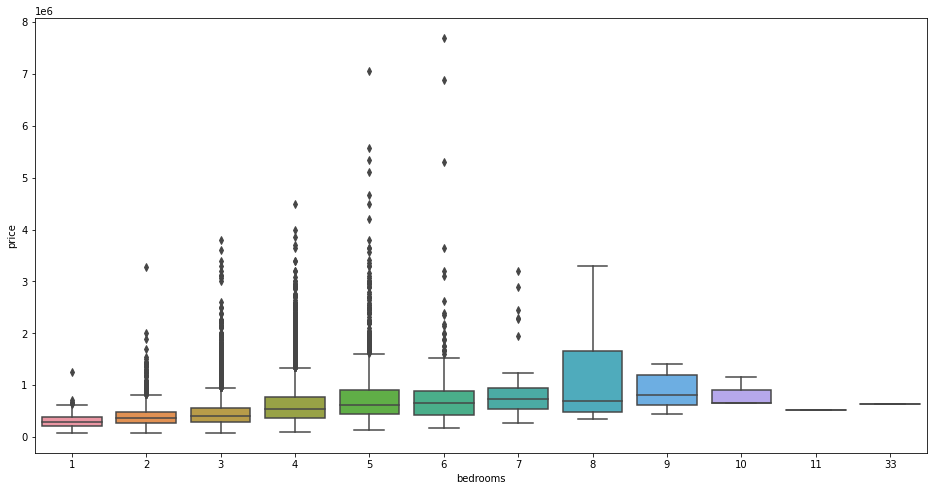

In [36]:
#box plot n bedrooms/saleprice
var = 'bedrooms'
data = pd.concat([price, hp_df[var]], axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="price", data=data)

Another feature that could relevant is the yr_renovated (renovation year). Unfourtunately this features has many records with value 0. We will ned to deal with this.

In [37]:
# Records with yr_renovated = 0

yr_renovated_n_0 = hp_df.yr_renovated.value_counts(dropna=False).sort_index()

print(f'The number of record with availabe info regarding the renovation year is {hp_df_shape[0] - yr_renovated_n_0[0]}.')


The number of record with availabe info regarding the renovation year is 914.


# Dropping Features

In [38]:
drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition"]

# id and date are useless for our analysis.
# sqft_lot, sqft_above, sqft_basement and sqft_lot15 are highly correlated with sqft_living and therefore redundant.
# the information contained in condition is already in grade and its correlation with price is very low. It can be dropped.

In [39]:
hp_df = hp_df.drop(columns = drop_columns)

# Data Transformations

## Building Age treatment

### Combine yr_built and yr_renovated into one single feature

What about if we combine the renovation year (with many zeros, possibly missing values) and the construction year into one single column. We will replace the construction year by the renovation year, for those records (very few) whit information regarding the renovation. This basically assumes that a building renovation equals to a new construction in terms of prices.

In [40]:
yr_built = hp_df["yr_built"].copy()
yr_renovated = hp_df["yr_renovated"].copy()
yr_ren_built = yr_renovated.where(yr_renovated != 0, other = yr_built)
yr_ren_built

0        1955
1        1991
2        1933
3        1965
4        1987
         ... 
21592    2009
21593    2014
21594    2009
21595    2004
21596    2008
Name: yr_renovated, Length: 21597, dtype: int64

Let us now convert this new feature into a variable representing the age.

In [41]:
max(yr_ren_built)

2015

In [42]:
age =  max(yr_ren_built) - yr_ren_built
age

0        60
1        24
2        82
3        50
4        28
         ..
21592     6
21593     1
21594     6
21595    11
21596     7
Name: yr_renovated, Length: 21597, dtype: int64

In [43]:
hp_df["age"] = age
hp_df = hp_df.drop(columns=["yr_renovated", "yr_built"])
hp_df

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,zipcode,lat,long,sqft_living15,price,age
0,3,1.00,1180,1.0,0,0,7,98178,47.5112,-122.257,1340,221900,60
1,3,2.25,2570,2.0,0,0,7,98125,47.7210,-122.319,1690,538000,24
2,2,1.00,770,1.0,0,0,6,98028,47.7379,-122.233,2720,180000,82
3,4,3.00,1960,1.0,0,0,7,98136,47.5208,-122.393,1360,604000,50
4,3,2.00,1680,1.0,0,0,8,98074,47.6168,-122.045,1800,510000,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,3.0,0,0,8,98103,47.6993,-122.346,1530,360000,6
21593,4,2.50,2310,2.0,0,0,8,98146,47.5107,-122.362,1830,400000,1
21594,2,0.75,1020,2.0,0,0,7,98144,47.5944,-122.299,1020,402101,6
21595,3,2.50,1600,2.0,0,0,8,98027,47.5345,-122.069,1410,400000,11


## Dropping row with 33 bedrooms

There is one record with 33 rooms that is obviously a typo. We will remove this row.

In [44]:
hp_df = hp_df[hp_df["bedrooms"] != 33]
hp_df

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,zipcode,lat,long,sqft_living15,price,age
0,3,1.00,1180,1.0,0,0,7,98178,47.5112,-122.257,1340,221900,60
1,3,2.25,2570,2.0,0,0,7,98125,47.7210,-122.319,1690,538000,24
2,2,1.00,770,1.0,0,0,6,98028,47.7379,-122.233,2720,180000,82
3,4,3.00,1960,1.0,0,0,7,98136,47.5208,-122.393,1360,604000,50
4,3,2.00,1680,1.0,0,0,8,98074,47.6168,-122.045,1800,510000,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,3.0,0,0,8,98103,47.6993,-122.346,1530,360000,6
21593,4,2.50,2310,2.0,0,0,8,98146,47.5107,-122.362,1830,400000,1
21594,2,0.75,1020,2.0,0,0,7,98144,47.5944,-122.299,1020,402101,6
21595,3,2.50,1600,2.0,0,0,8,98027,47.5345,-122.069,1410,400000,11


## Location Variables - dist_to_

Before starting the analysis, it is reasonable to expect that the location of the house has a significant impact on the house price. However the location estimators in the dataset (zipcode, long and lat) does not show a high correlation with the price. Can we engineer a new feature that better represent the house location?

In this section we will engineer a feature representing the disctance of each of the houses to a specific point, in our case to Seattle and two Bellevue. These two locations are hot spots, areas where the house prices are very high. To calculate the distance we will use the haversine function.

In [45]:
latlong = hp_df.loc[:, ['lat', 'long']]
latlong_tuple = list(zip(latlong.loc[:, 'lat'], latlong.loc[:, 'long']))
latlong["lat_long"] = latlong_tuple
latlong

,lat,long,lat_long
0,47.5112,-122.257,"(47.5112, -122.257)"
1,47.7210,-122.319,"(47.721, -122.319)"
2,47.7379,-122.233,"(47.7379, -122.233)"
3,47.5208,-122.393,"(47.5208, -122.393)"
4,47.6168,-122.045,"(47.6168, -122.045)"
...,...,...,...
21592,47.6993,-122.346,"(47.6993, -122.346)"
21593,47.5107,-122.362,"(47.5107, -122.362)"
21594,47.5944,-122.299,"(47.5944, -122.299)"
21595,47.5345,-122.069,"(47.5345, -122.069)"


In [46]:

dist_to_seattle = latlong.loc[:, 'lat_long'].apply(haversine, point2=(47.609395, -122.336283))

dist_to_bellevue = latlong.loc[:, 'lat_long'].apply(haversine, point2=(47.616492, -122.188985))

In [47]:
hp_df.loc[:, 'dist_to_seattle'] = dist_to_seattle
hp_df.loc[:, 'dist_to_bellevue'] = dist_to_bellevue

C:\Users\user\miniconda3\envs\DA_ENV\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


The correlation heatmap shows a better correlation with price of these new two features.

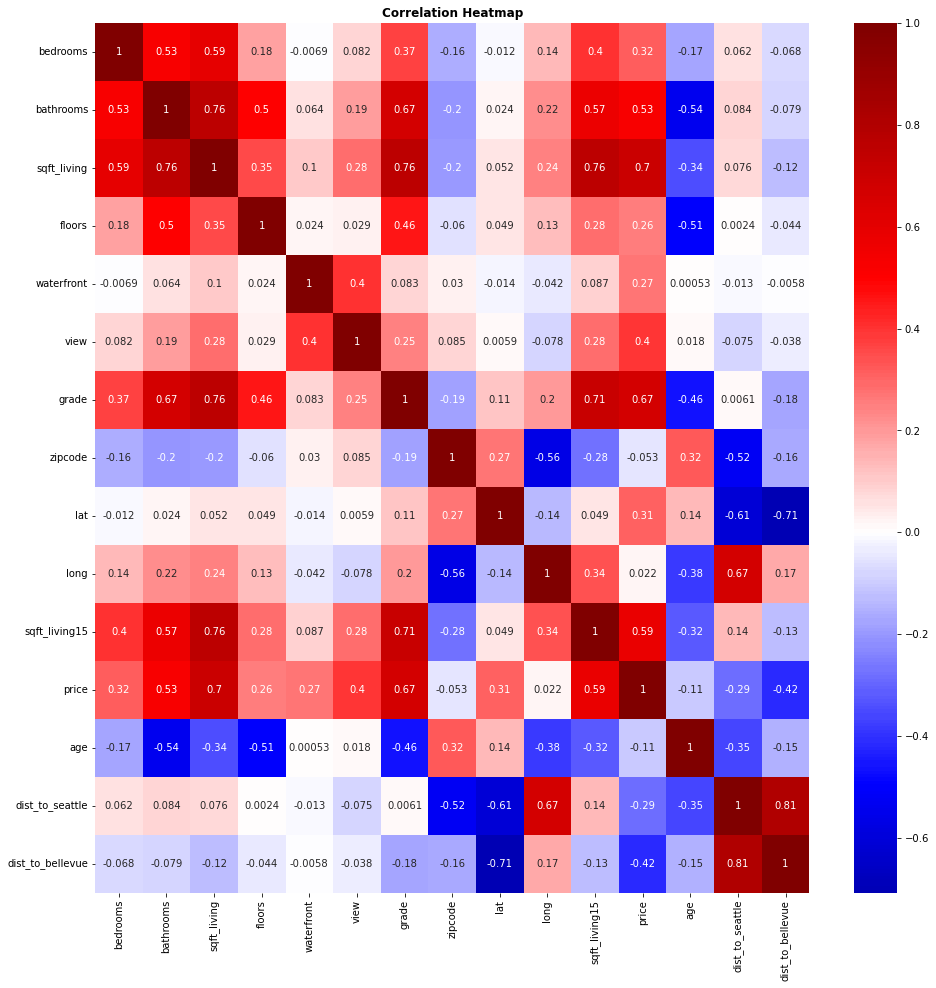

In [48]:
my_correlation_heatmap(hp_df, figsize=(16,16))

## Normalization - Price

Let us analyse how normal is the price distribution.

C:\Users\user\miniconda3\envs\DA_ENV\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


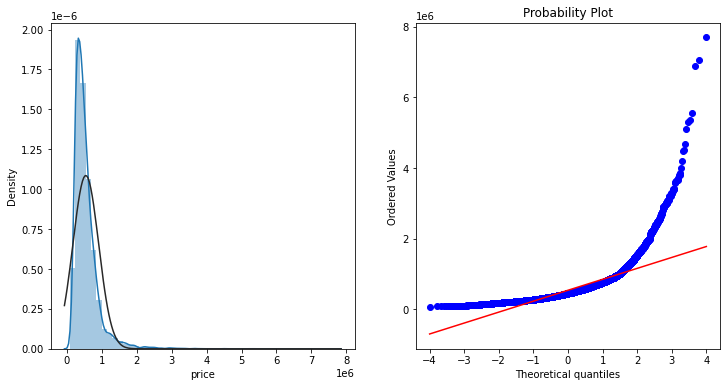

In [49]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (12,6))

sns.distplot(price,fit=norm, ax=axs[0])
result = probplot(price, plot=plt)

It is clear there is some room for improvement. Let us normalize the price. A logarithmic transformation usually works fine with distribution with long one sided tails.

### Logarithmic Transformation

In [50]:
price_log_norm = np.log(price)

C:\Users\user\miniconda3\envs\DA_ENV\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


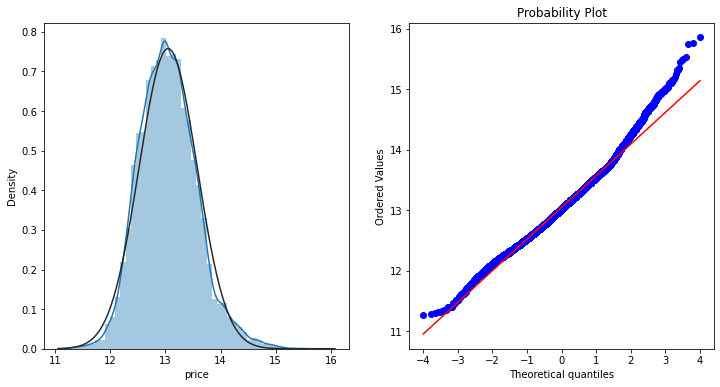

In [51]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (12,6))

sns.distplot(price_log_norm,fit=norm, ax=axs[0])
result = probplot(price_log_norm, plot=plt)

Now the price follows an almost perfect normal distribution.

## Normalization - sqft_living

We will do the same with our main numerical estimator, sqft_living.

C:\Users\user\miniconda3\envs\DA_ENV\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


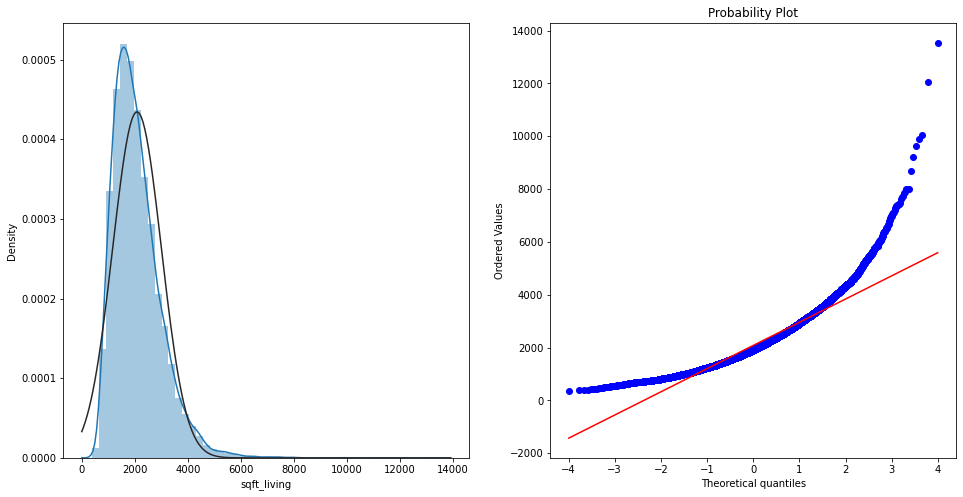

In [52]:
var = "sqft_living"

# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(hp_df[var],fit=norm, ax=axs[0])
result = probplot(hp_df[var], plot=plt)

### Power Transformation

This time we will be using a box-cox transformation.

In [53]:
sqft_living_transformer = PowerTransformer(method="box-cox").fit(hp_df[var].to_numpy().reshape(-1,1))
sqft_living_power_norm = sqft_living_transformer.transform(hp_df[var].to_numpy().reshape(-1,1))
sqft_living_power_norm = pd.DataFrame(sqft_living_power_norm)[0]

C:\Users\user\miniconda3\envs\DA_ENV\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


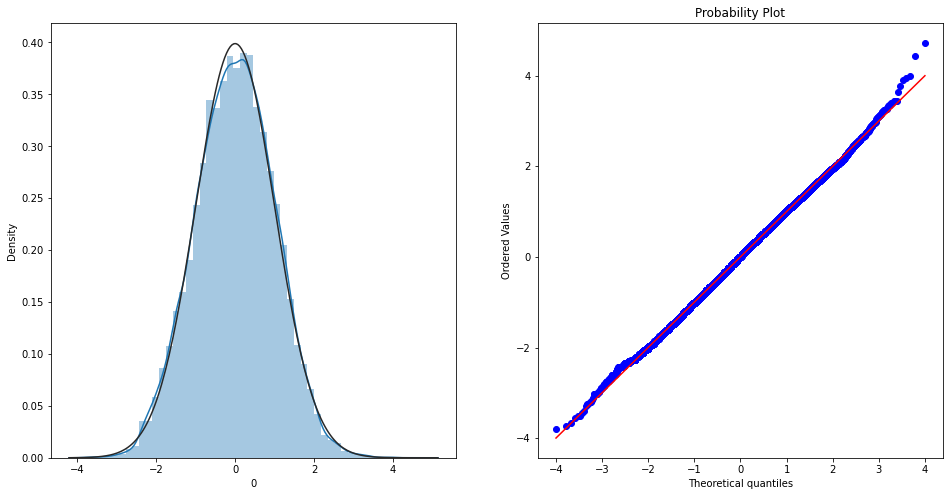

In [54]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(sqft_living_power_norm,fit=norm, ax=axs[0])
result = probplot(sqft_living_power_norm, plot=plt)

The resultant distribution again follows very closely the normal one.

# Regression Models

## Model 1 - Simple Linear Regression (sqft_living VS Price)

This first model is a very simple one: a linear regression using only the main numerical estimator, sqft_living.

In [55]:
# Pipeline

hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls", source_type="excel")
         .pipe(standard_headings)
         .pipe(remove_rows)
         .reset_index(drop=True)
         )

In [56]:
x = hp_df["sqft_living"]
y = hp_df["price"]


In [57]:
model1_transformed = my_transformations(x, y, test_size=0.2, numerical=True, scaler=None, categorical=False)

In [58]:
x_train = pd.DataFrame(model1_transformed["train"][0])
y_train = model1_transformed["train"][3]

x_test = pd.DataFrame(model1_transformed["test"][0])
y_test = model1_transformed["test"][3]

In [59]:
x_train

,sqft_living
0,2760
1,2940
2,1445
3,1810
4,1680
...,...
17271,1250
17272,998
17273,1460
17274,1120


In [60]:
y_train

0        424950
1        795000
2        387000
3        314000
4        935000
          ...  
17271    468000
17272    320000
17273    629000
17274    442500
17275    700000
Name: price, Length: 17276, dtype: int64

In [61]:
x_test

,sqft_living
0,3960
1,2750
2,1520
3,1910
4,1060
...,...
4315,2700
4316,1420
4317,1930
4318,3786


In [62]:
y_test

0        650000
1        635000
2        565000
3        415000
4        279475
         ...   
4315    1060000
4316     248000
4317     581000
4318    1380000
4319    1530000
Name: price, Length: 4320, dtype: int64

-----------------
The model score using K-fold cross validation (k=10) is 0.488 with a standard deviation of 0.022
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.488,-
val_std (k=10),0.022,-
mae,175705.327722,168161.005654
mse,70185746563.622528,61600031194.288284
rmse,264925.92656,248193.535762
r2,0.492215,0.49436
r2_adj,0.492186,0.494243


-----------------


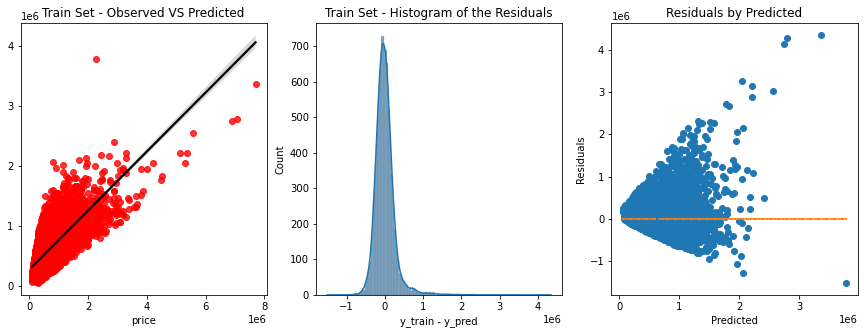

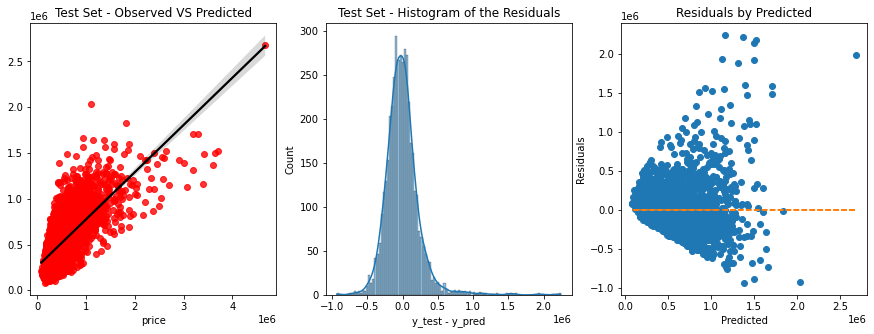

In [63]:
model1_output = regression(x_train, y_train, x_test, y_test, LinearRegression(), cv=10, verbose=True, plot=True, y_transformer=None)

## Model 2 - Multiple Linear Regression (all variables) - with statsmodels

In [64]:
# Inputs for the Pipeline Controller

drop_columns = ["id", "date"]

In [65]:
# Pipeline Control

hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls", source_type="excel")
         .pipe(standard_headings)
         .drop(drop_columns, axis=1)
         .pipe(remove_rows)
         .reset_index(drop=True)
        )

Model 2 considers all features (except id and date, which are irrelevant), no transformations and a linear regression.

In [66]:
y = hp_df["price"]
x = hp_df.drop(["price"], axis=1)


In [67]:
model2_transformed = my_transformations(x, y, test_size=0.2, numerical=True, scaler=None, categorical=True)

In [68]:
x_train = pd.concat([model2_transformed["train"][0], model2_transformed["train"][1]], axis=1)
y_train = model2_transformed["train"][3]

x_test = pd.concat([model2_transformed["test"][0], model2_transformed["test"][1]], axis=1)
y_test = model2_transformed["test"][3]

In [69]:
x_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,4,2.50,2760,5564,2.0,0,0,3,7,2760,0,2001,0,98056,47.4814,-122.189,2670,5626
1,3,2.75,2940,12487,2.0,0,0,3,10,2940,0,1997,0,98075,47.5879,-121.973,3110,10837
2,3,2.25,1445,1606,2.0,0,0,3,7,1300,145,2003,0,98027,47.5348,-122.072,1410,1286
3,3,1.75,1810,41800,1.0,0,0,5,7,1210,600,1980,0,98038,47.4109,-121.958,1650,135036
4,2,2.50,1680,977,3.0,0,0,3,9,1680,0,2009,0,98119,47.6320,-122.361,1680,977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17271,2,1.75,1250,7029,1.0,0,0,4,7,1250,0,1986,0,98033,47.6936,-122.186,1680,8470
17272,3,2.25,998,844,2.0,0,0,3,7,798,200,2007,0,98117,47.6983,-122.367,998,1110
17273,3,1.75,1460,12367,2.0,1,4,4,8,1120,340,1970,0,98023,47.3311,-122.375,1970,18893
17274,3,1.00,1120,8200,1.0,0,0,4,7,1120,0,1938,0,98125,47.7254,-122.290,1820,7205


In [70]:
y_train

0        424950
1        795000
2        387000
3        314000
4        935000
          ...  
17271    468000
17272    320000
17273    629000
17274    442500
17275    700000
Name: price, Length: 17276, dtype: int64

In [71]:
x_test

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,5,3.50,3960,25245,2.0,0,0,3,9,2500,1460,1996,0,98056,47.5250,-122.172,2640,13675
1,4,2.25,2750,6180,1.0,0,0,4,8,1500,1250,1948,0,98118,47.5691,-122.284,1740,6180
2,3,2.25,1520,1221,3.0,0,0,3,8,1520,0,2013,0,98107,47.6740,-122.377,1550,4750
3,3,1.75,1910,12596,1.0,0,0,3,7,1340,570,1977,0,98072,47.7399,-122.099,1550,13310
4,2,1.00,1060,10600,1.5,0,0,3,6,1060,0,1968,0,98065,47.5375,-121.742,1560,21344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,3,2.75,2700,22343,1.5,0,1,4,10,2700,0,1977,0,98040,47.5706,-122.209,3390,15682
4316,3,1.00,1420,8800,1.0,0,0,4,6,1090,330,1981,0,98030,47.3746,-122.181,1480,8000
4317,2,1.75,1930,11200,1.0,0,2,3,8,1430,500,1951,0,98177,47.7576,-122.370,2840,12408
4318,3,3.25,3786,38038,1.0,1,4,3,9,1934,1852,1978,2006,98070,47.3907,-122.448,2850,33361


In [72]:
y_test

0        650000
1        635000
2        565000
3        415000
4        279475
         ...   
4315    1060000
4316     248000
4317     581000
4318    1380000
4319    1530000
Name: price, Length: 4320, dtype: int64

In [73]:
# Summary from statsmodels

x_train_const = sm.add_constant(x_train)  

model = sm.OLS(y_train, x_train_const).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     2344.
Date:                Thu, 30 Dec 2021   Prob (F-statistic):               0.00
Time:                        19:30:08   Log-Likelihood:            -2.3576e+05
No. Observations:               17276   AIC:                         4.716e+05
Df Residuals:                   17258   BIC:                         4.717e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          7.047e+06   3.34e+06      2.109

The hypothesis testing shows that sqft_lot and floors don't have an impact on the house price. The t value also shows that grade and sqft_living are the two more important features.

-----------------
The model score using K-fold cross validation (k=10) is 0.697 with a standard deviation of 0.014
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.697,-
val_std (k=10),0.014,-
mae,127843.42888,123003.345818
mse,41775053573.945305,35039849597.448273
rmse,204389.465418,187189.34157
r2,0.697763,0.712377
r2_adj,0.697448,0.711174


-----------------


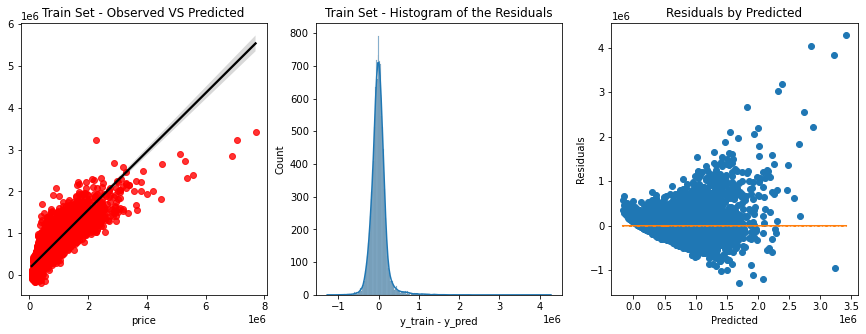

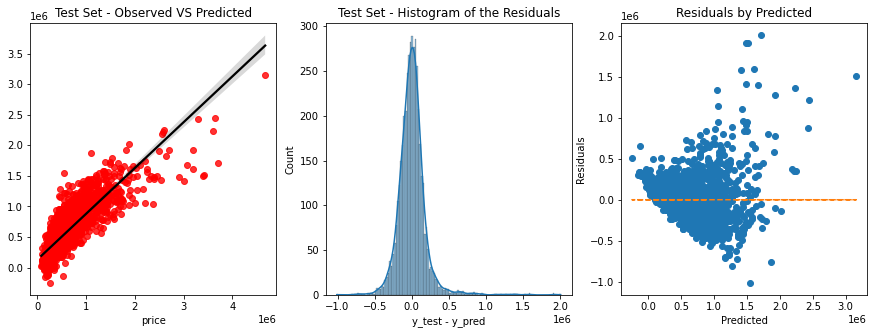

In [74]:
model2_output = regression(x_train, y_train, x_test, y_test, LinearRegression(), cv=10, verbose=True, plot=True, y_transformer=None)

## Model 3 - Multiple Linear Regression - Reduced number of variables and Transformations

In [75]:
# Inputs for the Pipeline Controller

drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition", "floors", "sqft_living15"]

In [76]:
# Pipeline Control

hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls", source_type="excel")
                   .pipe(standard_headings)
                   .drop(drop_columns, axis=1)
                   .pipe(transform_renovated_built)  # Combination of yr_built and yr_renovated into one single feature
                   .pipe(remove_rows)
                   .reset_index(drop=True)
                   .pipe(normalizations)     # Price and sqft_living Normalization
                   .pipe(dist_to)            # Location Enigeneered Feature
                   )

Model 3 considers a reduced set of features, the discussed transformations and a linear regression.

In [77]:
y = hp_df["price"]
x = hp_df.drop(["price"], axis=1)


In [78]:
model3_transformed = my_transformations(x, y, test_size=0.2, numerical=True, scaler=None, categorical=True)

In [79]:
x_train = pd.concat([model3_transformed["train"][0], model3_transformed["train"][1]], axis=1)
y_train = model3_transformed["train"][3]

x_test = pd.concat([model3_transformed["test"][0], model3_transformed["test"][1]], axis=1)
y_test = model3_transformed["test"][3]

In [80]:
x_train

,bedrooms,bathrooms,sqft_living,waterfront,view,grade,age,zipcode,lat,long,dist_to_seattle,dist_to_bellevue
0,4,2.50,0.876559,0,0,7,14,98056,47.4814,-122.189,18.021294,15.021566
1,3,2.75,1.026851,0,0,10,18,98075,47.5879,-121.973,27.343975,16.502820
2,3,2.25,-0.650752,0,0,7,12,98027,47.5348,-122.072,21.491409,12.630283
3,3,1.75,-0.121692,0,0,7,35,98038,47.4109,-121.958,35.977700,28.697640
4,2,2.50,-0.297071,0,0,9,6,98119,47.6320,-122.361,3.122476,13.006370
...,...,...,...,...,...,...,...,...,...,...,...,...
17271,2,1.75,-0.989895,0,0,7,29,98033,47.6936,-122.186,14.642023,8.576945
17272,3,2.25,-1.514454,0,0,7,8,98117,47.6983,-122.367,10.150001,16.140358
17273,3,1.75,-0.626550,1,4,8,45,98023,47.3311,-122.375,31.081572,34.677381
17274,3,1.00,-1.246077,0,0,7,77,98125,47.7254,-122.290,13.356670,14.278059


In [81]:
y_train

0        12.959727
1        13.586097
2        12.866180
3        12.657148
4        13.748302
           ...    
17271    13.056224
17272    12.676076
17273    13.351887
17274    13.000196
17275    13.458836
Name: price, Length: 17276, dtype: float64

In [82]:
x_test

,bedrooms,bathrooms,sqft_living,waterfront,view,grade,age,zipcode,lat,long,dist_to_seattle,dist_to_bellevue
0,5,3.50,1.738198,0,0,9,19,98056,47.5250,-122.172,15.491396,10.252949
1,4,2.25,0.867930,0,0,8,67,98118,47.5691,-122.284,5.953955,8.862148
2,3,2.25,-0.532115,0,0,8,2,98107,47.6740,-122.377,7.804606,15.468616
3,3,1.75,0.005027,0,0,7,38,98072,47.7399,-122.099,22.939251,15.286891
4,2,1.00,-1.374288,0,0,6,47,98065,47.5375,-121.742,45.292405,34.660616
...,...,...,...,...,...,...,...,...,...,...,...,...
4315,3,2.75,0.824324,0,1,10,38,98040,47.5706,-122.209,10.474895,5.319109
4316,3,1.00,-0.691639,0,0,6,34,98030,47.3746,-122.181,28.596295,26.903889
4317,2,1.75,0.029590,0,2,8,64,98177,47.7576,-122.370,16.671837,20.731314
4318,3,3.25,1.630576,1,4,9,9,98070,47.3907,-122.448,25.725246,31.763361


In [83]:
y_test

0       13.384728
1       13.361380
2       13.244581
3       12.936034
4       12.540668
          ...    
4315    13.873779
4316    12.421184
4317    13.272506
4318    14.137594
4319    14.240778
Name: price, Length: 4320, dtype: float64

-----------------
The model score using K-fold cross validation (k=10) is 0.796 with a standard deviation of 0.009
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.796,-
val_std (k=10),0.009,-
mae,99744.8195,95112.131971
mse,28327461860.105709,24459968938.103619
rmse,168307.640528,156396.831611
r2,0.795055,0.799222
r2_adj,0.794912,0.798662


-----------------


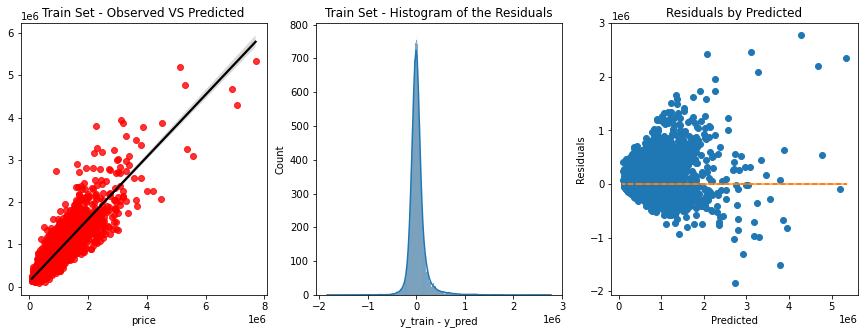

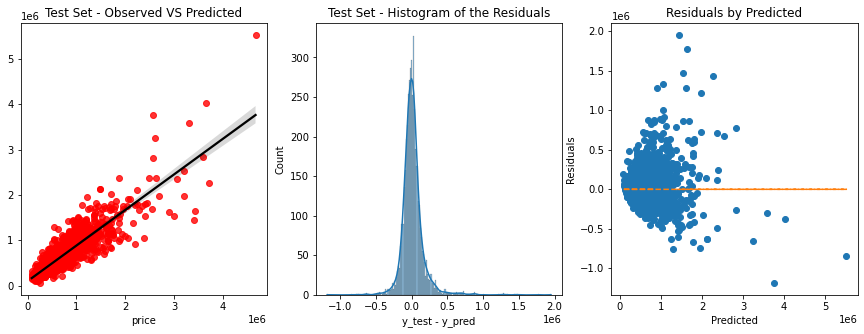

In [84]:
model3_output = regression(x_train, y_train, x_test, y_test, LinearRegression(), cv=10, verbose=True, plot=True, y_transformer="log")

## Model 4 - Ridge Regression

In [85]:
# Inputs for the Pipeline Controller

drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition", "floors", "sqft_living15"]

In [86]:
# Pipeline Control

hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls", source_type="excel")
                   .pipe(standard_headings)
                   .drop(drop_columns, axis=1)
                   .pipe(transform_renovated_built)  # Combination of yr_built and yr_renovated into one single feature
                   .pipe(remove_rows)
                   .reset_index(drop=True)
                   .pipe(normalizations)     # Price and sqft_living Normalization
                   .pipe(dist_to)            # Location Enigeneered Feature
                   )

Model 4 considers a reduced set of features, the discussed transformations and a ridge regression.

In [87]:
y = hp_df["price"]
x = hp_df.drop(["price"], axis=1)


In [88]:
model4_transformed = my_transformations(x, y, test_size=0.2, numerical=True, scaler=None, categorical=True)

In [89]:
x_train = pd.concat([model4_transformed["train"][0], model4_transformed["train"][1]], axis=1)
y_train = model4_transformed["train"][3]

x_test = pd.concat([model4_transformed["test"][0], model4_transformed["test"][1]], axis=1)
y_test = model4_transformed["test"][3]

In [90]:
x_train

,bedrooms,bathrooms,sqft_living,waterfront,view,grade,age,zipcode,lat,long,dist_to_seattle,dist_to_bellevue
0,4,2.50,0.876559,0,0,7,14,98056,47.4814,-122.189,18.021294,15.021566
1,3,2.75,1.026851,0,0,10,18,98075,47.5879,-121.973,27.343975,16.502820
2,3,2.25,-0.650752,0,0,7,12,98027,47.5348,-122.072,21.491409,12.630283
3,3,1.75,-0.121692,0,0,7,35,98038,47.4109,-121.958,35.977700,28.697640
4,2,2.50,-0.297071,0,0,9,6,98119,47.6320,-122.361,3.122476,13.006370
...,...,...,...,...,...,...,...,...,...,...,...,...
17271,2,1.75,-0.989895,0,0,7,29,98033,47.6936,-122.186,14.642023,8.576945
17272,3,2.25,-1.514454,0,0,7,8,98117,47.6983,-122.367,10.150001,16.140358
17273,3,1.75,-0.626550,1,4,8,45,98023,47.3311,-122.375,31.081572,34.677381
17274,3,1.00,-1.246077,0,0,7,77,98125,47.7254,-122.290,13.356670,14.278059


In [91]:
y_train

0        12.959727
1        13.586097
2        12.866180
3        12.657148
4        13.748302
           ...    
17271    13.056224
17272    12.676076
17273    13.351887
17274    13.000196
17275    13.458836
Name: price, Length: 17276, dtype: float64

In [92]:
x_test

,bedrooms,bathrooms,sqft_living,waterfront,view,grade,age,zipcode,lat,long,dist_to_seattle,dist_to_bellevue
0,5,3.50,1.738198,0,0,9,19,98056,47.5250,-122.172,15.491396,10.252949
1,4,2.25,0.867930,0,0,8,67,98118,47.5691,-122.284,5.953955,8.862148
2,3,2.25,-0.532115,0,0,8,2,98107,47.6740,-122.377,7.804606,15.468616
3,3,1.75,0.005027,0,0,7,38,98072,47.7399,-122.099,22.939251,15.286891
4,2,1.00,-1.374288,0,0,6,47,98065,47.5375,-121.742,45.292405,34.660616
...,...,...,...,...,...,...,...,...,...,...,...,...
4315,3,2.75,0.824324,0,1,10,38,98040,47.5706,-122.209,10.474895,5.319109
4316,3,1.00,-0.691639,0,0,6,34,98030,47.3746,-122.181,28.596295,26.903889
4317,2,1.75,0.029590,0,2,8,64,98177,47.7576,-122.370,16.671837,20.731314
4318,3,3.25,1.630576,1,4,9,9,98070,47.3907,-122.448,25.725246,31.763361


In [93]:
y_test

0       13.384728
1       13.361380
2       13.244581
3       12.936034
4       12.540668
          ...    
4315    13.873779
4316    12.421184
4317    13.272506
4318    14.137594
4319    14.240778
Name: price, Length: 4320, dtype: float64

-----------------
The model score using K-fold cross validation (k=10) is 0.785 with a standard deviation of 0.009
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.785,-
val_std (k=10),0.009,-
mae,102159.430854,97264.501068
mse,29147482750.698483,24867593997.635639
rmse,170726.338773,157694.622602
r2,0.789122,0.795876
r2_adj,0.788975,0.795307


-----------------


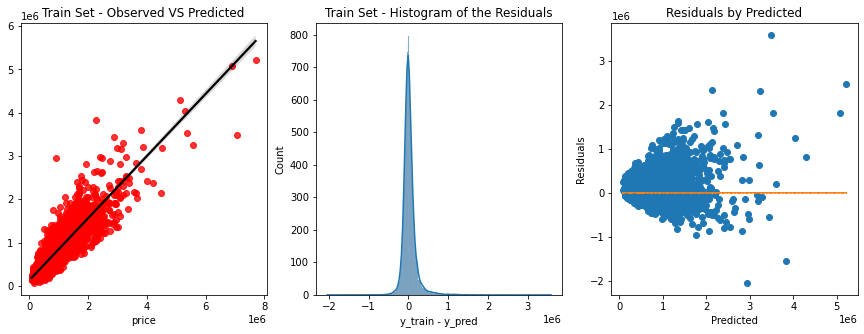

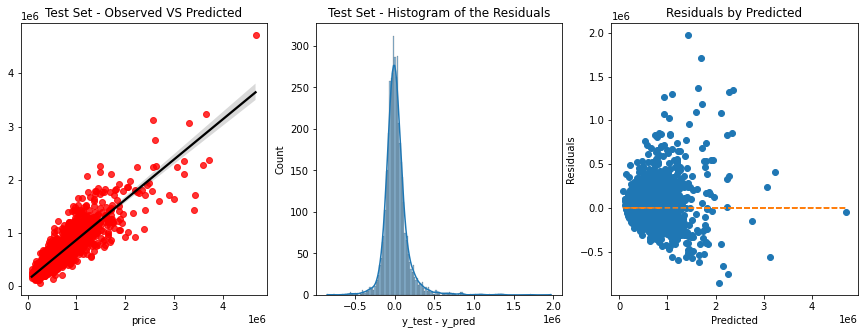

In [94]:
model4_output = regression(x_train, y_train, x_test, y_test, Ridge(alpha=100), cv=10, verbose=True, plot=True, y_transformer="log")

Ridge is not bringing any improvement. Kind of expected, the model is not too complex, on the contrary is lacking complexity.

## Model 5 - Lasso Regression

In [95]:
# Inputs for the Pipeline Controller

drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition", "floors", "sqft_living15"]

In [96]:
# Pipeline Control

hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls", source_type="excel")
                   .pipe(standard_headings)
                   .drop(drop_columns, axis=1)
                   .pipe(transform_renovated_built)  # Combination of yr_built and yr_renovated into one single feature
                   .pipe(remove_rows)
                   .reset_index(drop=True)
                   .pipe(normalizations)     # Price and sqft_living Normalization
                   .pipe(dist_to)            # Location Enigeneered Feature
                   )

Model 5 considers a reduced set of features, the discussed transformations and a Lasso regression.

In [97]:
y = hp_df["price"]
x = hp_df.drop(["price"], axis=1)


In [98]:
model5_transformed = my_transformations(x, y, test_size=0.2, numerical=True, scaler=None, categorical=True)

In [99]:
x_train = pd.concat([model5_transformed["train"][0], model5_transformed["train"][1]], axis=1)
y_train = model5_transformed["train"][3]

x_test = pd.concat([model5_transformed["test"][0], model5_transformed["test"][1]], axis=1)
y_test = model5_transformed["test"][3]

In [100]:
x_train

,bedrooms,bathrooms,sqft_living,waterfront,view,grade,age,zipcode,lat,long,dist_to_seattle,dist_to_bellevue
0,4,2.50,0.876559,0,0,7,14,98056,47.4814,-122.189,18.021294,15.021566
1,3,2.75,1.026851,0,0,10,18,98075,47.5879,-121.973,27.343975,16.502820
2,3,2.25,-0.650752,0,0,7,12,98027,47.5348,-122.072,21.491409,12.630283
3,3,1.75,-0.121692,0,0,7,35,98038,47.4109,-121.958,35.977700,28.697640
4,2,2.50,-0.297071,0,0,9,6,98119,47.6320,-122.361,3.122476,13.006370
...,...,...,...,...,...,...,...,...,...,...,...,...
17271,2,1.75,-0.989895,0,0,7,29,98033,47.6936,-122.186,14.642023,8.576945
17272,3,2.25,-1.514454,0,0,7,8,98117,47.6983,-122.367,10.150001,16.140358
17273,3,1.75,-0.626550,1,4,8,45,98023,47.3311,-122.375,31.081572,34.677381
17274,3,1.00,-1.246077,0,0,7,77,98125,47.7254,-122.290,13.356670,14.278059


In [101]:
y_train

0        12.959727
1        13.586097
2        12.866180
3        12.657148
4        13.748302
           ...    
17271    13.056224
17272    12.676076
17273    13.351887
17274    13.000196
17275    13.458836
Name: price, Length: 17276, dtype: float64

In [102]:
x_test

,bedrooms,bathrooms,sqft_living,waterfront,view,grade,age,zipcode,lat,long,dist_to_seattle,dist_to_bellevue
0,5,3.50,1.738198,0,0,9,19,98056,47.5250,-122.172,15.491396,10.252949
1,4,2.25,0.867930,0,0,8,67,98118,47.5691,-122.284,5.953955,8.862148
2,3,2.25,-0.532115,0,0,8,2,98107,47.6740,-122.377,7.804606,15.468616
3,3,1.75,0.005027,0,0,7,38,98072,47.7399,-122.099,22.939251,15.286891
4,2,1.00,-1.374288,0,0,6,47,98065,47.5375,-121.742,45.292405,34.660616
...,...,...,...,...,...,...,...,...,...,...,...,...
4315,3,2.75,0.824324,0,1,10,38,98040,47.5706,-122.209,10.474895,5.319109
4316,3,1.00,-0.691639,0,0,6,34,98030,47.3746,-122.181,28.596295,26.903889
4317,2,1.75,0.029590,0,2,8,64,98177,47.7576,-122.370,16.671837,20.731314
4318,3,3.25,1.630576,1,4,9,9,98070,47.3907,-122.448,25.725246,31.763361


In [103]:
y_test

0       13.384728
1       13.361380
2       13.244581
3       12.936034
4       12.540668
          ...    
4315    13.873779
4316    12.421184
4317    13.272506
4318    14.137594
4319    14.240778
Name: price, Length: 4320, dtype: float64

-----------------
The model score using K-fold cross validation (k=10) is 0.257 with a standard deviation of 0.011
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.257,-
val_std (k=10),0.011,-
mae,194448.256494,188997.388138
mse,122021634267.348358,104495358361.812607
rmse,349315.951922,323257.418108
r2,0.117189,0.142256
r2_adj,0.116576,0.139866


-----------------


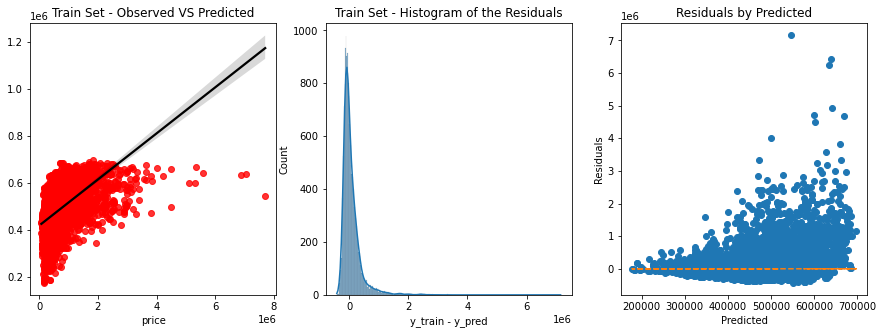

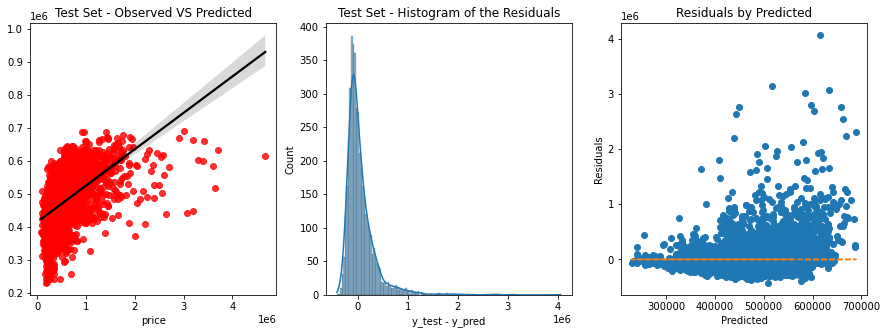

In [104]:
model5_output = regression(x_train, y_train, x_test, y_test, Lasso(alpha=1), cv=10, verbose=True, plot=True, y_transformer="log")

Lasso is not working properly, unless we use ver low alphas. Makes sense, we have very few features and Lasso even reducing some more.

## Model 6 - Polynomial Regression

In [105]:
# Inputs for the Pipeline Controller

drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition", "floors", "sqft_living15"]

In [106]:
# Pipeline Control

hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls", source_type="excel")
                   .pipe(standard_headings)
                   .drop(drop_columns, axis=1)
                   .pipe(transform_renovated_built)  # Combination of yr_built and yr_renovated into one single feature
                   .pipe(remove_rows)
                   .reset_index(drop=True)
                   .pipe(normalizations)     # Price and sqft_living Normalization
                   .pipe(dist_to)            # Location Enigeneered Feature
                   )

Model 6 considers a reduced set of features, the discussed transformations and a polynomial regression of order 2.

In [107]:
y = hp_df["price"]
x = hp_df.drop(["price"], axis=1)


In [108]:
model6_transformed = my_transformations(x, y, test_size=0.2, numerical=True, scaler=None, categorical=True)

In [109]:
x_train = pd.concat([model6_transformed["train"][0], model6_transformed["train"][1]], axis=1)
y_train = model6_transformed["train"][3]

x_test = pd.concat([model6_transformed["test"][0], model6_transformed["test"][1]], axis=1)
y_test = model6_transformed["test"][3]

In [110]:
x_train

,bedrooms,bathrooms,sqft_living,waterfront,view,grade,age,zipcode,lat,long,dist_to_seattle,dist_to_bellevue
0,4,2.50,0.876559,0,0,7,14,98056,47.4814,-122.189,18.021294,15.021566
1,3,2.75,1.026851,0,0,10,18,98075,47.5879,-121.973,27.343975,16.502820
2,3,2.25,-0.650752,0,0,7,12,98027,47.5348,-122.072,21.491409,12.630283
3,3,1.75,-0.121692,0,0,7,35,98038,47.4109,-121.958,35.977700,28.697640
4,2,2.50,-0.297071,0,0,9,6,98119,47.6320,-122.361,3.122476,13.006370
...,...,...,...,...,...,...,...,...,...,...,...,...
17271,2,1.75,-0.989895,0,0,7,29,98033,47.6936,-122.186,14.642023,8.576945
17272,3,2.25,-1.514454,0,0,7,8,98117,47.6983,-122.367,10.150001,16.140358
17273,3,1.75,-0.626550,1,4,8,45,98023,47.3311,-122.375,31.081572,34.677381
17274,3,1.00,-1.246077,0,0,7,77,98125,47.7254,-122.290,13.356670,14.278059


In [111]:
y_train

0        12.959727
1        13.586097
2        12.866180
3        12.657148
4        13.748302
           ...    
17271    13.056224
17272    12.676076
17273    13.351887
17274    13.000196
17275    13.458836
Name: price, Length: 17276, dtype: float64

In [112]:
x_test

,bedrooms,bathrooms,sqft_living,waterfront,view,grade,age,zipcode,lat,long,dist_to_seattle,dist_to_bellevue
0,5,3.50,1.738198,0,0,9,19,98056,47.5250,-122.172,15.491396,10.252949
1,4,2.25,0.867930,0,0,8,67,98118,47.5691,-122.284,5.953955,8.862148
2,3,2.25,-0.532115,0,0,8,2,98107,47.6740,-122.377,7.804606,15.468616
3,3,1.75,0.005027,0,0,7,38,98072,47.7399,-122.099,22.939251,15.286891
4,2,1.00,-1.374288,0,0,6,47,98065,47.5375,-121.742,45.292405,34.660616
...,...,...,...,...,...,...,...,...,...,...,...,...
4315,3,2.75,0.824324,0,1,10,38,98040,47.5706,-122.209,10.474895,5.319109
4316,3,1.00,-0.691639,0,0,6,34,98030,47.3746,-122.181,28.596295,26.903889
4317,2,1.75,0.029590,0,2,8,64,98177,47.7576,-122.370,16.671837,20.731314
4318,3,3.25,1.630576,1,4,9,9,98070,47.3907,-122.448,25.725246,31.763361


In [113]:
y_test

0       13.384728
1       13.361380
2       13.244581
3       12.936034
4       12.540668
          ...    
4315    13.873779
4316    12.421184
4317    13.272506
4318    14.137594
4319    14.240778
Name: price, Length: 4320, dtype: float64

In [114]:
# Polynomial Transformation - order n

n = 2
polynomial_features= PolynomialFeatures(degree=n)
x_train_poly = polynomial_features.fit_transform(x_train)
x_test_poly = polynomial_features.transform(x_test)

-----------------
The model score using K-fold cross validation (k=10) is 0.858 with a standard deviation of 0.008
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.858,-
val_std (k=10),0.008,-
mae,80407.977267,76537.870269
mse,18460581587.268875,16854008217.016916
rmse,135869.72285,129822.988015
r2,0.86644,0.861655
r2_adj,0.865733,0.858677


-----------------


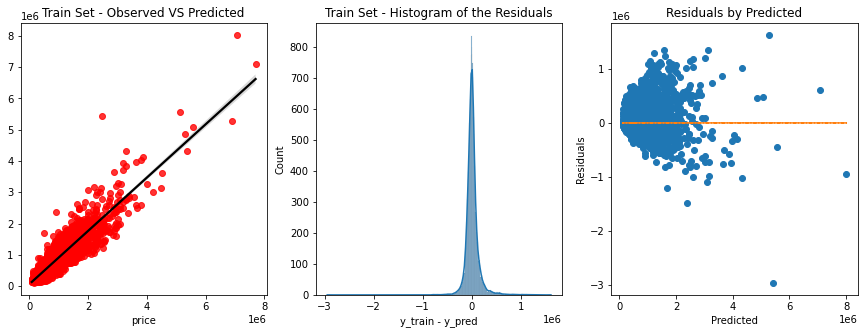

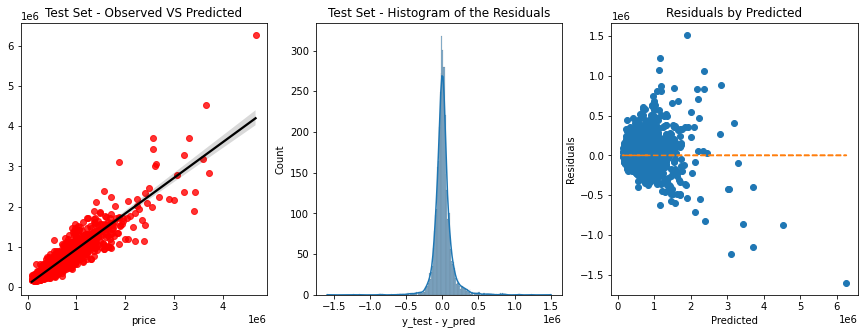

In [115]:
model6_output = regression(x_train_poly, y_train, x_test_poly, y_test, LinearRegression(), cv=10, verbose=True, plot=True, y_transformer="log")

## Model 7 - XGBoost

In [116]:
# Inputs for the Pipeline Controller

drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition", "floors", "sqft_living15"]

In [117]:
# Pipeline Control

hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls", source_type="excel")
                   .pipe(standard_headings)
                   .drop(drop_columns, axis=1)
                   .pipe(transform_renovated_built)  # Combination of yr_built and yr_renovated into one single feature
                   .pipe(remove_rows)
                   .reset_index(drop=True)
                   .pipe(normalizations)     # Price and sqft_living Normalization
                   .pipe(dist_to)            # Location Enigeneered Feature
                   )

Model 7 considers a reduced set of features, the discussed transformations and a Extreme Gradient Boost model.

In [118]:
y = hp_df["price"]
x = hp_df.drop(["price"], axis=1)


In [119]:
model7_transformed = my_transformations(x, y, test_size=0.2, numerical=True, scaler=None, categorical=True)

In [120]:
x_train = pd.concat([model7_transformed["train"][0], model7_transformed["train"][1]], axis=1)
y_train = model7_transformed["train"][3]

x_test = pd.concat([model7_transformed["test"][0], model7_transformed["test"][1]], axis=1)
y_test = model7_transformed["test"][3]

In [121]:
x_train

,bedrooms,bathrooms,sqft_living,waterfront,view,grade,age,zipcode,lat,long,dist_to_seattle,dist_to_bellevue
0,4,2.50,0.876559,0,0,7,14,98056,47.4814,-122.189,18.021294,15.021566
1,3,2.75,1.026851,0,0,10,18,98075,47.5879,-121.973,27.343975,16.502820
2,3,2.25,-0.650752,0,0,7,12,98027,47.5348,-122.072,21.491409,12.630283
3,3,1.75,-0.121692,0,0,7,35,98038,47.4109,-121.958,35.977700,28.697640
4,2,2.50,-0.297071,0,0,9,6,98119,47.6320,-122.361,3.122476,13.006370
...,...,...,...,...,...,...,...,...,...,...,...,...
17271,2,1.75,-0.989895,0,0,7,29,98033,47.6936,-122.186,14.642023,8.576945
17272,3,2.25,-1.514454,0,0,7,8,98117,47.6983,-122.367,10.150001,16.140358
17273,3,1.75,-0.626550,1,4,8,45,98023,47.3311,-122.375,31.081572,34.677381
17274,3,1.00,-1.246077,0,0,7,77,98125,47.7254,-122.290,13.356670,14.278059


In [122]:
y_train

0        12.959727
1        13.586097
2        12.866180
3        12.657148
4        13.748302
           ...    
17271    13.056224
17272    12.676076
17273    13.351887
17274    13.000196
17275    13.458836
Name: price, Length: 17276, dtype: float64

In [123]:
x_test

,bedrooms,bathrooms,sqft_living,waterfront,view,grade,age,zipcode,lat,long,dist_to_seattle,dist_to_bellevue
0,5,3.50,1.738198,0,0,9,19,98056,47.5250,-122.172,15.491396,10.252949
1,4,2.25,0.867930,0,0,8,67,98118,47.5691,-122.284,5.953955,8.862148
2,3,2.25,-0.532115,0,0,8,2,98107,47.6740,-122.377,7.804606,15.468616
3,3,1.75,0.005027,0,0,7,38,98072,47.7399,-122.099,22.939251,15.286891
4,2,1.00,-1.374288,0,0,6,47,98065,47.5375,-121.742,45.292405,34.660616
...,...,...,...,...,...,...,...,...,...,...,...,...
4315,3,2.75,0.824324,0,1,10,38,98040,47.5706,-122.209,10.474895,5.319109
4316,3,1.00,-0.691639,0,0,6,34,98030,47.3746,-122.181,28.596295,26.903889
4317,2,1.75,0.029590,0,2,8,64,98177,47.7576,-122.370,16.671837,20.731314
4318,3,3.25,1.630576,1,4,9,9,98070,47.3907,-122.448,25.725246,31.763361


In [124]:
y_test

0       13.384728
1       13.361380
2       13.244581
3       12.936034
4       12.540668
          ...    
4315    13.873779
4316    12.421184
4317    13.272506
4318    14.137594
4319    14.240778
Name: price, Length: 4320, dtype: float64

-----------------
The model score using K-fold cross validation (k=10) is 0.889 with a standard deviation of 0.006
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.889,-
val_std (k=10),0.006,-
mae,60956.700839,65192.324438
mse,9745305798.354521,11669437521.371962
rmse,98718.315415,108025.170777
r2,0.929494,0.904212
r2_adj,0.929445,0.903945


-----------------


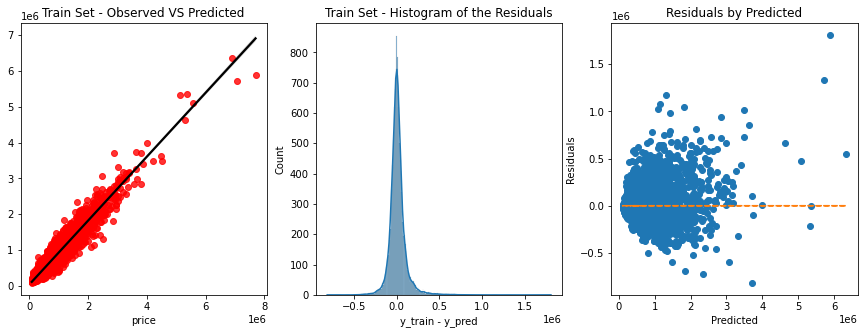

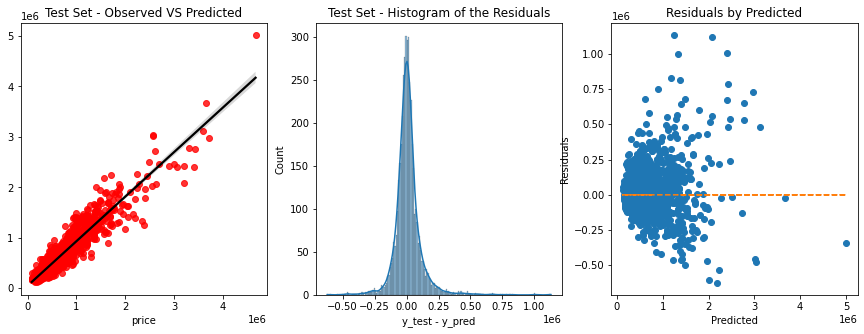

In [125]:
model7_output = regression(x_train, y_train, x_test, y_test, xgboost.XGBRegressor(n_estimators=90, learning_rate=0.1, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=6), cv=10, verbose=True, plot=True, y_transformer="log")

# Conclusion

- An Extreme Grandient Boosting (XGB) model with an adjusted R2=0.9 has been developed to prediced the price of houses in Kings County Area, Seattle. 
- The most revelant estimators are the living area (sqft_living) and the building grade (quality).
- This high performance has been obtained using only 12 estimators.
- Normalization of the price and the living area demonstrated to be very powerful in this dataset, bringing a 4% improvement on the adjusted R2
- The Location Engineered Features brought a 6%  improvement on the adjusted R2. These feature are based on the dataset longitud and latitud data and represent the distance of each house to two hot-spots (areas with very high prices), belleveu and downtown Seattle
- There are a lot of outliers in the data (houses with very prices). However it makes sense to keep them as they are part of the nature of the data. There are house with very high prices on the market but with very specific characteristics: huge living space, water access, very high grade, very nice locations